In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import scikitplot

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

## Preview Data 

[Dataset](https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge)

In [2]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

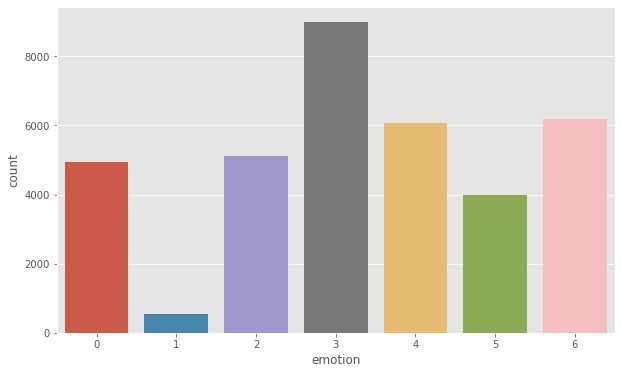

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(df['emotion']);

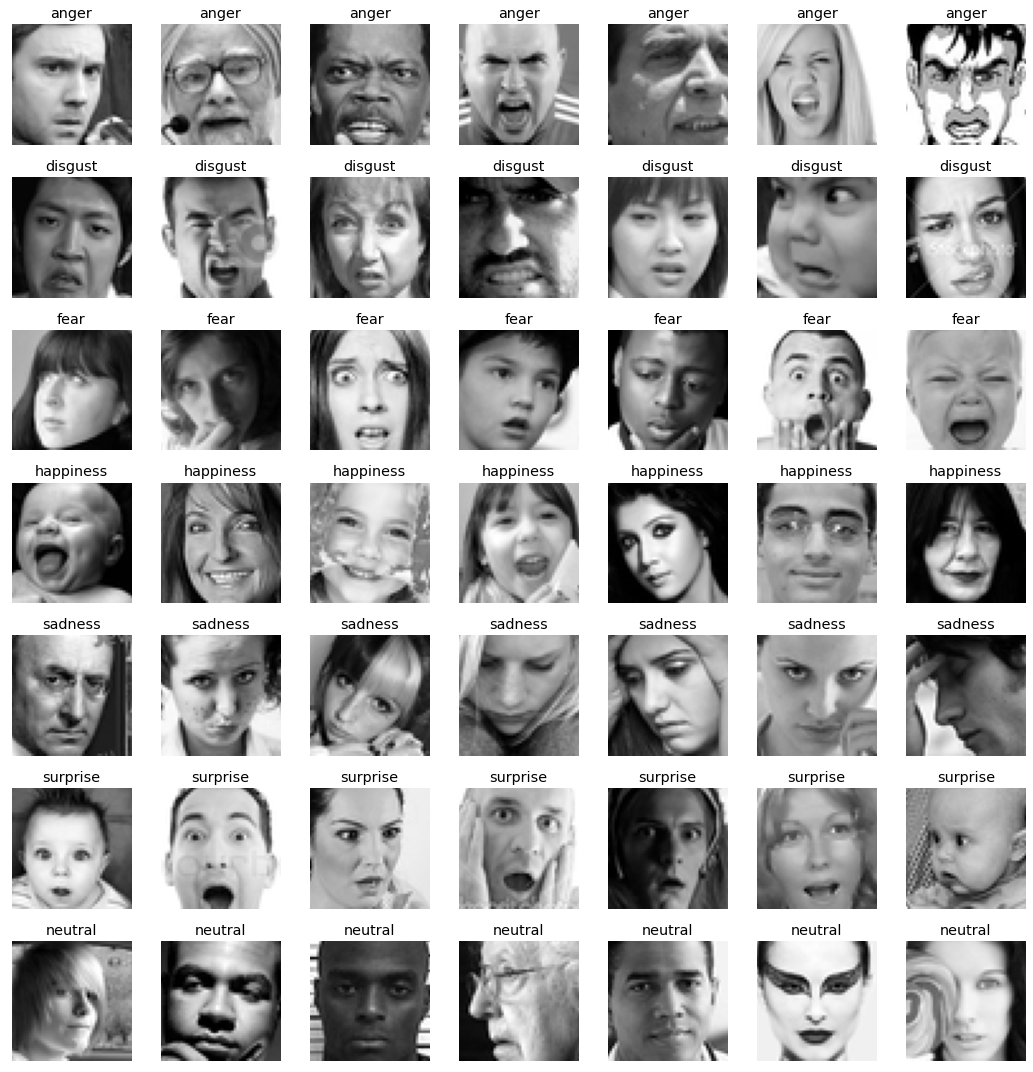

In [6]:
plt.figure(figsize=(15,15))
k = 0

for label in sorted(df.emotion.unique()):
    for j in range(7):
        
        # Get image with index k
        img = df[df.emotion==label].pixels.iloc[k]
        img = np.array(img.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        
        # Plot images
        ax = plt.subplot(7, 7, k)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()
        
plt.show()

## Prepare Data 

In [7]:
# Select only happy, sad, neutral emotion because the lack of data on other labels
df = df[df.emotion.isin([3,4,6])]
df.shape

(21264, 3)

In [8]:
# Convert to array to be compatible with neural networks
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(21264, 48, 48, 1)

In [9]:
# Convert labels to categorical
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [10]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [11]:
# Split data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, 
                                                      shuffle=True, stratify=img_labels,
                                                      test_size=0.2, random_state=21)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((17011, 48, 48, 1), (4253, 48, 48, 1), (17011, 3), (4253, 3))

In [12]:
# Free memory
del df
del img_array
del img_labels

In [13]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [14]:
# Normalizing data
X_train = X_train / 255.
X_valid = X_valid / 255.

## Train Model

In [16]:
# Function for convolutional block
def conv2d_block(filters, kernel_size, input_shape=False):
    return Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  input_shape=input_shape,
                  activation='elu',
                  padding='same',
                  kernel_initializer='he_normal')

In [17]:
model = Sequential([
    
    conv2d_block(64, (5,5), input_shape=(img_width, img_height, img_depth)),
    BatchNormalization(),
    
    conv2d_block(64, (5,5)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    conv2d_block(128, (3,3)),
    BatchNormalization(),
    
    conv2d_block(128, (3,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    conv2d_block(256, (3,3)),
    BatchNormalization(),
    
    conv2d_block(256, (3,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    
    Flatten(),
    Dense(128, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# EarlyStoppling to reduce overfitting and ReduceLROnPlateau for learning rate
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [early_stopping, lr_scheduler]

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [20]:
batch_size = 32
epochs = 100

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/100
532/531 [==============================] - 12s 22ms/step - loss: 1.3425 - accuracy: 0.3986 - val_loss: 1.0472 - val_accuracy: 0.4500
Epoch 2/100
532/531 [==============================] - 10s 19ms/step - loss: 1.0391 - accuracy: 0.4752 - val_loss: 1.0372 - val_accuracy: 0.4820
Epoch 3/100
532/531 [==============================] - 10s 19ms/step - loss: 0.9858 - accuracy: 0.5177 - val_loss: 0.8990 - val_accuracy: 0.5709
Epoch 4/100
532/531 [==============================] - 11s 20ms/step - loss: 0.9083 - accuracy: 0.5660 - val_loss: 0.9705 - val_accuracy: 0.5683
Epoch 5/100
532/531 [==============================] - 10s 19ms/step - loss: 0.8332 - accuracy: 0.6020 - val_loss: 0.7900 - val_accuracy: 0.6327
Epoch 6/100
532/531 [==============================] - 11s 21ms/step - loss: 0.7734 - accuracy: 0.6380 - val_loss: 0.7074 - val_accuracy: 0.6783
Epoch 7/100
532/531 [==============================] - 11s 21ms/step - loss: 0.7382 - accuracy: 0.6615 - val_loss: 0.6809 - val_ac

Epoch 56/100
532/531 [==============================] - 12s 22ms/step - loss: 0.4447 - accuracy: 0.8192 - val_loss: 0.5196 - val_accuracy: 0.7891
Epoch 57/100
532/531 [==============================] - 11s 20ms/step - loss: 0.4440 - accuracy: 0.8187 - val_loss: 0.5167 - val_accuracy: 0.7903
Epoch 58/100
532/531 [==============================] - 11s 20ms/step - loss: 0.4445 - accuracy: 0.8188 - val_loss: 0.5135 - val_accuracy: 0.7886
Epoch 00058: early stopping


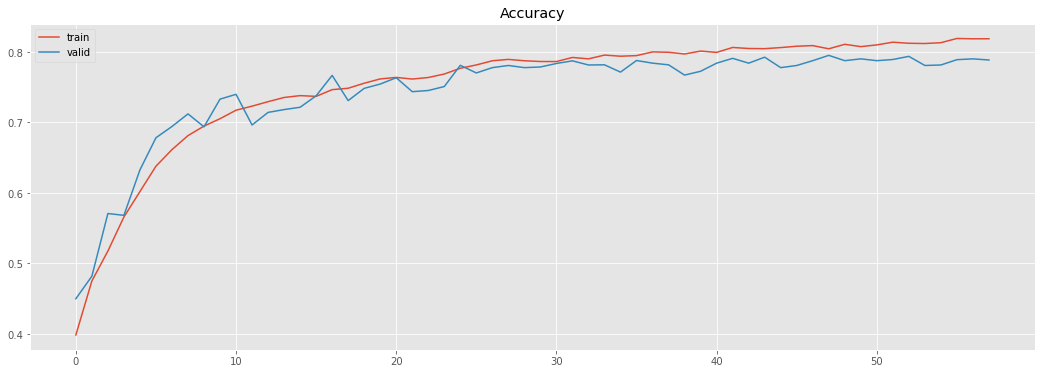

In [22]:
plt.figure(figsize=(18, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [23]:
model.save('emotion_detection_model.h5')

Total wrong validation predictions: 871


              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1798
           1       0.73      0.74      0.73      1215
           2       0.70      0.70      0.70      1240

    accuracy                           0.80      4253
   macro avg       0.78      0.78      0.78      4253
weighted avg       0.80      0.80      0.80      4253



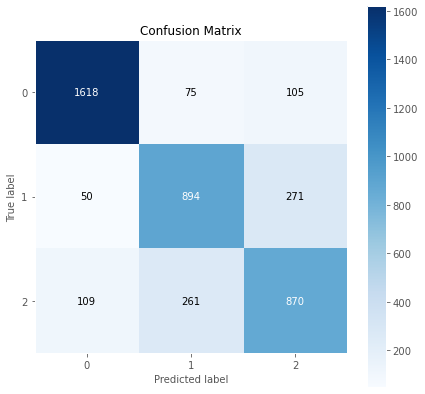

In [26]:
y_pred = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), y_pred, figsize=(7,7))

print(f'Total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != y_pred)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), y_pred))

In [27]:
mapper = {0: "happy", 1: "sad", 2: "neutral"}

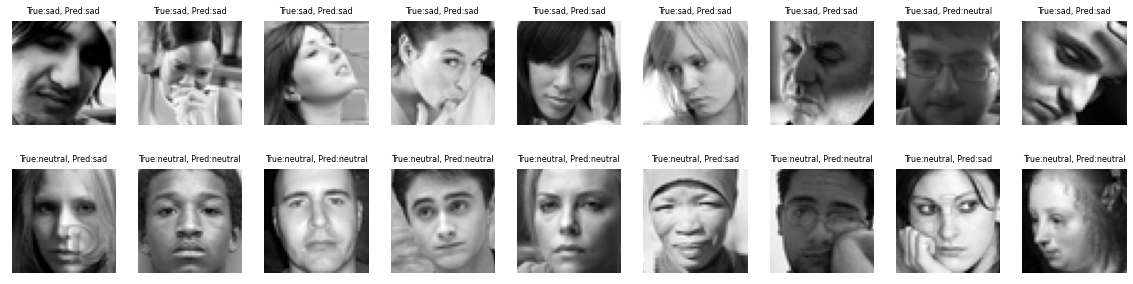

In [34]:
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

plt.figure(figsize=(20,5))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"True:sad, Pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}", fontsize=8)

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"True:neutral, Pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}", fontsize=8)
        
plt.show()